# Metric learning in TensorFlow

In [1]:
import os
import sys
sys.path.append(os.pardir)

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tf_simple_metric_learning.layers import ArcFace, AdaCos, CircleLossCL

/Users/daigo.hiroka/.pyenv/versions/3.6.5/envs/tf-metric/lib/python3.6/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [16]:
EPOCHS = 10
BATCH_SIZE = 32
IMAGE_SIZE = (256, 256)

## Inspect CUB-200 dataset

In [2]:
dataset, info = tfds.load('caltech_birds2011', with_info=True, split='train')
num_classes = 200
info

tfds.core.DatasetInfo(
    name='caltech_birds2011',
    version=0.1.0,
    description='Caltech-UCSD Birds 200 (CUB-200) is an image dataset with photos 
of 200 bird species (mostly North American). The total number of 
categories of birds is 200 and there are 6033 images in the 2010 
dataset and 11,788 images in the 2011 dataset.
Annotations include bounding boxes, segmentation labels.',
    homepage='http://www.vision.caltech.edu/visipedia/CUB-200.html',
    features=FeaturesDict({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=200),
        'label_name': Text(shape=(), dtype=tf.string),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=tf.uint8),
    }),
    total_num_examples=11788,
    splits={
        'test': 5794,
        'train': 5994,
    },
    supervised_keys=('im

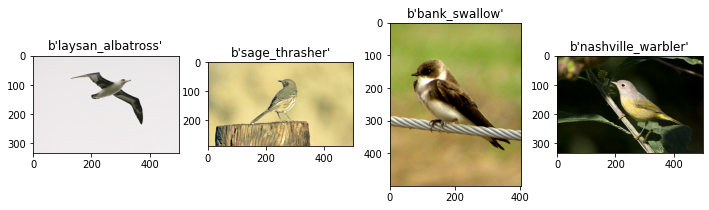

In [3]:
n_show_samples = 4

fig, axes = plt.subplots(1, n_show_samples, figsize=(12, 3))
for i, (sample) in enumerate(dataset.take(n_show_samples)):
    axes[i].set_title(sample['label_name'].numpy())
    axes[i].imshow(sample['image'].numpy())
plt.show()    

In [31]:
ds_train, ds_test = tfds.load('caltech_birds2011', as_supervised=True, split=['train', 'test'])

# def generate_sample(image, label):
#     return (image, label), label

ds_train = ds_train.map(lambda image, label: (tf.image.resize(image, size=IMAGE_SIZE), label), num_parallel_calls=1).batch(BATCH_SIZE)
ds_test = ds_test.map(lambda image, label: (tf.image.resize(image, size=IMAGE_SIZE), label), num_parallel_calls=1).batch(BATCH_SIZE)

## Build model

In [12]:
inputs = tf.keras.layers.Input([None, None, 3], dtype=tf.uint8)
x = tf.cast(inputs, dtype=tf.float32)
# x = tf.keras.applications.resnet50.preprocess_input(x)
tf.keras.applications.efficientnet.preprocess_input(x)

# net = tf.keras.applications.DenseNet121(include_top=False, weights='imagenet', pooling='avg')
net = tf.keras.applications.EfficientNetB0(include_top=False, weights='imagenet', pooling='avg')
embeds = net(x)

labels = tf.keras.layers.Input([], dtype=tf.int32)
labels_onehot = tf.one_hot(labels, depth=num_classes)

metric_layer = ArcFace(num_classes=num_classes, margin=0.5, scale=64)
logits = metric_layer([embeds, labels_onehot])

model = tf.keras.Model(inputs=[inputs, labels], outputs=logits)
model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
tf_op_layer_Cast_2 (TensorFlowO [(None, None, None,  0           input_7[0][0]                    
__________________________________________________________________________________________________
input_9 (InputLayer)            [(None,)]            0                                            
__________________________________________________________________________________________________
efficientnetb0 (Functional)     (None, 1280)         4049571     tf_op_layer_Cast_2[0][0]         
_______________________________________________________________________________________

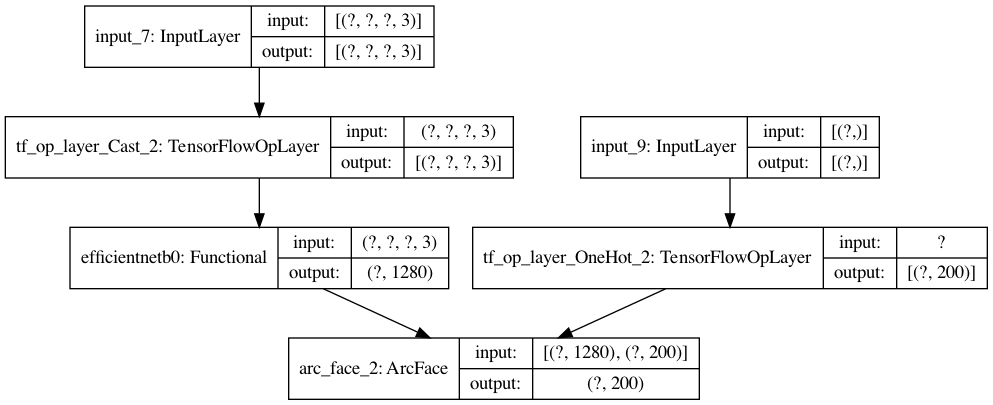

In [13]:
tf.keras.utils.plot_model(model, show_shapes=True)

## Compile and Fit

In [39]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy()
optimizer = tf.keras.optimizers.Adam()

for e in range(EPOCHS):
    for i, (images, labels) in enumerate(ds_train):
        with tf.GradientTape() as tape:
            logits = model([images, labels], training=True) 
            loss = loss_fn(labels, logits)
            metric.update_state(labels, logits)
            
            gradients = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(gradients, model.trainable_weights))
        
        accuracy = metric.result().numpy()
        print(f'Epoch: {e+1}/{EPOCHS}, batch: {i+1}/{len(ds_train)}, accuracy: {accuracy}')
    metric.reset_states()

Epoch: 1/10, batch: 1/188, accuracy: 0.0
Epoch: 1/10, batch: 2/188, accuracy: 0.0
Epoch: 1/10, batch: 3/188, accuracy: 0.0


KeyboardInterrupt: 

In [42]:
labels, logits, loss

(<tf.Tensor: shape=(32,), dtype=int64, numpy=
 array([ 77, 159, 128, 171,  76, 136,  75, 138, 171, 181, 146, 162, 196,
        155,  44, 146,  32,   4, 186, 147, 130,  83, 113,   2,  93,  75,
        124,  10, 133, 119,  65,  44])>,
 <tf.Tensor: shape=(32, 200), dtype=float32, numpy=
 array([[-2.9923918 ,  2.91898   , -2.1934114 , ...,  0.7638223 ,
         -0.46830285, -0.28083467],
        [ 0.481515  , -0.97971815, -1.8927604 , ..., -0.7804869 ,
          0.3601215 ,  0.10822004],
        [-0.44525152, -2.6632707 , -3.6850305 , ..., -1.2487175 ,
          0.712967  , -0.19278216],
        ...,
        [-0.991046  , -1.6435428 , -1.6354125 , ..., -0.7790873 ,
         -2.4822729 , -1.2939463 ],
        [-4.907233  ,  0.10988915, -0.8966793 , ...,  0.5533782 ,
          0.276134  , -0.25883323],
        [-1.1933826 ,  4.8785057 ,  2.458122  , ...,  1.4337826 ,
          1.2628617 , -2.648983  ]], dtype=float32)>,
 <tf.Tensor: shape=(), dtype=float32, numpy=37.036118>)

In [27]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=tf.keras.metrics.SparseCategoricalAccuracy()
)

In [30]:
model.fit(
    ds_train,
    epochs=EPOCHS,
    validation_data=ds_test,
)

Epoch 1/10


ValueError: Creating variables on a non-first call to a function decorated with tf.function.